In [47]:
import os  # For interacting with the file system
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations

# Define the directory where the raw ASCII XBT profile .txt files are stored
raw_data_dir = '/Users/alistairblair/AX08_Project/Logs, summary and report/ascii'

# Initialize empty lists to store profile data and associated metadata
profiles = []     # Will store DataFrames of profile data
meta_list = []    # Will store metadata dictionaries for each profile

# Loop through all files in the directory
for filename in os.listdir(raw_data_dir):
    # Only process files ending with .txt
    if filename.endswith('.txt'):
        filepath = os.path.join(raw_data_dir, filename)  # Get full path to the file

        try:
            # Try reading the .txt file as a CSV (assumes it’s comma- or space-separated)
            df = pd.read_csv(filepath)
        except Exception as e:
            # If it fails to read (e.g. wrong format), print a message and skip this file
            print(f"Skipping {filename}: {e}")
            continue

        # Add a column to identify the profile by its filename
        df['Profile'] = filename

        # Add basic metadata — currently only stores the filename and a placeholder for Latitude
        meta_list.append({'Filename': filename, 'Latitude': np.nan})

        # Append the DataFrame to the list of profiles
        profiles.append(df)

In [48]:
# Define the path to the folder containing the raw XBT profile .txt files
ascii_folder = '/Users/alistairblair/AX08_Project/Logs, summary and report/ascii'

# Create a list of all files in that folder that end with ".txt"
txt_files = [f for f in os.listdir(ascii_folder) if f.endswith('.txt')]

# Print out how many such files were found (i.e., how many profiles you have)
print(f"Found {len(txt_files)} profile files")

Found 517 profile files


In [49]:
# --- Helper function to convert latitude string to decimal degrees ---
def parse_lat(lat_str):
    """Convert lat string like '33 47.86  N' to decimal degrees."""
    parts = lat_str.strip().split()  # Split string by spaces: ['33', '47.86', 'N']
    deg = float(parts[0])            # Degrees part
    minute = float(parts[1])         # Minutes part
    sign = -1 if parts[2].upper() == 'S' else 1  # South = negative, North = positive
    return sign * (deg + minute / 60)  # Convert to decimal degrees

profiles = []     # List to hold all profile DataFrames
meta_list = []    # List to hold extracted metadata (lat, lon, date, etc.) from each file

# Loop over each .txt file found earlier
for file in txt_files:
    path = os.path.join(ascii_folder, file)  # Full path to the current file

    with open(path, 'r') as f:
        lines = f.readlines()  # Read all lines from the file

    meta = {'file': file}      # Start metadata dictionary for this file
    start_index = None         # We'll figure out where the actual data starts

    for idx, line in enumerate(lines):
        if "Date" in line and "Time" in line:
            # Extract date string from line like: 'Date=2008-06-13, Time=13:45'
            meta['Date'] = line.split(',')[0].split('=')[1].strip()
        if "Latitude" in line and "Longitude" in line:
            # Extract and parse latitude and longitude
            lat_str = line.split(',')[0].split('=')[1].strip()
            lon_str = line.split(',')[1].split('=')[1].strip()
            meta['Latitude_str'] = lat_str
            meta['Longitude_str'] = lon_str
            meta['Latitude'] = parse_lat(lat_str)
        if "Full Resolution Values" in line:
            # This marks the start of profile data — actual readings begin 2 lines below
            start_index = idx + 2
            break

    if start_index is None:
        print(f"Warning: No data found in file {file}")
        continue  # Skip to next file if no data section was found

    # Get the data block from that point forward
    data_str = ''.join(lines[start_index:])

    # Use StringIO to make the string readable as a CSV
    from io import StringIO
    df = pd.read_csv(StringIO(data_str), sep=r',\s*', engine='python', names=['Depth', 'Temp'])

    # Add profile name and latitude to the DataFrame
    df['Profile'] = file
    df['Latitude'] = meta['Latitude']

    # Save cleaned DataFrame and metadata
    profiles.append(df)
    meta_list.append(meta)

In [50]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.signal import medfilt  # For median filtering to reduce noise

# --- Configuration for cleaning thresholds ---
TEMP_RANGE = (-2, 40)                      # Acceptable temperature range (°C)
DEPTH_RANGE = (0, 2000)                    # Acceptable depth range (m)
MAX_GRADIENT = 0.08                        # Max allowed temperature gradient (°C/m)
SPIKE_DIFF_THRESHOLD = 3.0                 # Threshold to detect local spikes
ROLLING_DEV_THRESHOLD = 2.5                # Max deviation from rolling median to consider a value valid
ROLLING_WINDOW = 11                        # Window size for rolling median
SPIKE_ZONE = (600, 850)                    # Depth zone to watch closely for spikes
SPIKE_ZONE_DEV_THRESHOLD = 1.5             # Tolerance for spike detection within SPIKE_ZONE
FLAT_SEGMENT_THRESHOLD = 0.8               # If too much of the profile is flat, discard it
STEEP_MEDIAN_GRADIENT = 0.1                # Too steep median gradient → discard
MAX_DEPTH_DIFF = 10                        # Max allowed step between depth readings (low resolution filter)

# --- Dictionary to track statistics on cleaning outcomes ---
stats = {
    'total': 0,
    'cleaned': 0,
    'not_monotonic': 0,
    'missing': 0,
    'range': 0,
    'low_resolution': 0,
    'inversion': 0,
    'long_flat': 0,
    'bottom_temp_spike': 0,
    'steep_gradient': 0,
    'too_short': 0,
    'error': 0,
}

# --- Cleaning utility functions ---

def is_monotonic(df):
    # Checks that depth increases consistently throughout the profile
    return (df['Depth'].diff().dropna() > 0).all()

def min_valid_profile(df, min_points=15):
    # Ensures a profile has at least `min_points` data points
    return len(df) >= min_points

def remove_missing(df):
    # Drops rows with any missing (NaN) values
    return df.dropna()

def remove_out_of_range(df):
    # Filters out values that fall outside valid temp/depth ranges
    return df[
        (df['Temp'] >= TEMP_RANGE[0]) & (df['Temp'] <= TEMP_RANGE[1]) &
        (df['Depth'] >= DEPTH_RANGE[0]) & (df['Depth'] <= DEPTH_RANGE[1])
    ]

def remove_low_resolution(df, max_step=MAX_DEPTH_DIFF):
    # Reject profile if any jump in depth is too large
    depth_diff = df['Depth'].diff()
    if depth_diff.max() > max_step:
        return None
    return df

def remove_local_spikes(df):
    # Removes sharp temperature spikes by checking differences between neighbors
    df['diff_prev'] = df['Temp'].diff().abs()
    df['diff_next'] = df['Temp'].diff(-1).abs()
    mask = (
        (df['diff_prev'] < SPIKE_DIFF_THRESHOLD) | df['diff_prev'].isna()
    ) & (
        (df['diff_next'] < SPIKE_DIFF_THRESHOLD) | df['diff_next'].isna()
    )
    return df[mask].drop(columns=['diff_prev', 'diff_next'])

def remove_flat_segments(df, tolerance=0.05):
    # Removes long stretches of nearly constant temperature
    temp_diff = df['Temp'].diff()
    long_flat = temp_diff.abs().rolling(window=5).sum() < tolerance
    return df[~long_flat.fillna(False)]

def remove_sudden_horizontal_spikes(df):
    # Removes points with very steep local gradients
    df['temp_grad'] = df['Temp'].diff() / df['Depth'].diff()
    df = df[(df['temp_grad'].isna()) | (df['temp_grad'] <= MAX_GRADIENT)]
    return df.drop(columns=['temp_grad'])

def remove_excessive_gradient(df):
    # Removes rows where vertical gradient exceeds MAX_GRADIENT
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    gradient = temp_diff / depth_diff
    return df[(gradient.isna()) | (gradient <= MAX_GRADIENT)]

def remove_spikes_in_zone(df):
    # Removes spike anomalies specifically in a predefined depth zone (e.g., 600–850 m)
    in_zone = df['Depth'].between(*SPIKE_ZONE)
    rolling_median = df.loc[in_zone, 'Temp'].rolling(window=7, center=True).median()
    deviation = (df.loc[in_zone, 'Temp'] - rolling_median).abs()
    good_points = (deviation < SPIKE_ZONE_DEV_THRESHOLD) | deviation.isna()
    return df.drop(index=df.loc[in_zone].index[~good_points])

def remove_long_constant_temp(df, max_const_length=20):
    # Rejects profile if a single temperature value is repeated too many times
    repeat_lengths = (df['Temp'].round(2).diff() != 0).astype(int).cumsum()
    max_run = repeat_lengths.value_counts().max()
    if max_run >= max_const_length:
        return None
    return df

def apply_median_filter(df):
    # Smooths temperature using a median filter
    if len(df) >= 7:
        df['Temp'] = medfilt(df['Temp'], kernel_size=7)
    return df

def remove_global_outliers(df):
    # Removes global outliers based on rolling deviation from median
    rolling_median = df['Temp'].rolling(window=ROLLING_WINDOW, center=True).median()
    deviation = (df['Temp'] - rolling_median).abs()
    return df[(deviation < ROLLING_DEV_THRESHOLD) | deviation.isna()]

def enforce_physical_gradient(df):
    # Enforces a stricter gradient threshold in shallow water and relaxed deeper
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    gradient = temp_diff / depth_diff
    keep = (gradient.isna()) | (gradient <= MAX_GRADIENT)
    relaxed = df['Depth'] > 800
    keep_bottom = (gradient[relaxed] <= 0.3) | (gradient[relaxed].isna())
    keep.loc[relaxed] = keep_bottom.values
    return df[keep]

def remove_surface_inversion(df, threshold=0.5):
    # Rejects profile if surface temperature is too warm compared to 10–20 m layer
    surface_temp = df.loc[df['Depth'] <= 5, 'Temp'].mean()
    deeper_temp = df.loc[(df['Depth'] >= 10) & (df['Depth'] <= 20), 'Temp'].mean()
    if pd.notna(surface_temp) and pd.notna(deeper_temp) and (surface_temp - deeper_temp > threshold):
        return None
    return df

# --- Main function to clean a single profile ---

def clean_profile(df):
    try:
        stats['total'] += 1
        df = df.copy()

        if not is_monotonic(df):
            stats['not_monotonic'] += 1
            return None

        df = remove_missing(df)
        if df.isnull().any().any():
            stats['missing'] += 1
            return None

        df = remove_out_of_range(df)
        if df.empty:
            stats['range'] += 1
            return None

        df = remove_low_resolution(df)
        if df is None:
            stats['low_resolution'] += 1
            return None

        if remove_surface_inversion(df) is None:
            stats['inversion'] += 1
            return None

        # Apply full cleaning chain
        df = remove_local_spikes(df)
        df = remove_flat_segments(df)
        df = remove_sudden_horizontal_spikes(df)
        df = remove_excessive_gradient(df)
        df = remove_spikes_in_zone(df)
        df = apply_median_filter(df)
        df = remove_global_outliers(df)
        df = enforce_physical_gradient(df)
        df = remove_long_constant_temp(df)
        if df is None:
            stats['long_flat'] += 1
            return None

        df = df.reset_index(drop=True)

        # Discard if very deep temperatures exceed 22°C (unlikely)
        if (df.loc[df['Depth'] > 800, 'Temp'] > 22).any():
            stats['bottom_temp_spike'] += 1
            return None

        # Reject if most of profile is nearly flat
        flat_segments = df['Temp'].diff().abs() < 0.05
        if flat_segments.sum() / len(df) > 0.95:  # previously 0.8
            stats['long_flat'] += 1
            return None

        # Reject if median gradient is too steep
        median_gradient = (df['Temp'].diff() / df['Depth'].diff()).median()
        if pd.notna(median_gradient) and median_gradient > STEEP_MEDIAN_GRADIENT:
            stats['steep_gradient'] += 1
            return None

        # Reject if too few data points
        if not min_valid_profile(df):
            stats['too_short'] += 1
            return None

        # If passed all filters, add to cleaned count
        stats['cleaned'] += 1
        return df

    except Exception as e:
        # Catch unexpected errors during cleaning
        stats['error'] += 1
        print(f"Error cleaning profile: {e}")
        return None

# --- Apply cleaning function to all profiles ---

cleaned_profiles = []
for df in profiles:
    cleaned = clean_profile(df)
    if cleaned is not None:
        cleaned_profiles.append(cleaned)

# Attach latitude metadata to each cleaned profile
for df, meta in zip(cleaned_profiles, meta_list):
    df['Latitude'] = meta.get('Latitude', np.nan)

# --- Print a summary of the cleaning outcomes ---

print("\n✅ Cleaning Summary:")
for k, v in stats.items():
    print(f"{k:20s}: {v}")


✅ Cleaning Summary:
total               : 517
cleaned             : 491
not_monotonic       : 0
missing             : 0
range               : 0
low_resolution      : 1
inversion           : 17
long_flat           : 1
bottom_temp_spike   : 5
steep_gradient      : 0
too_short           : 2
error               : 0


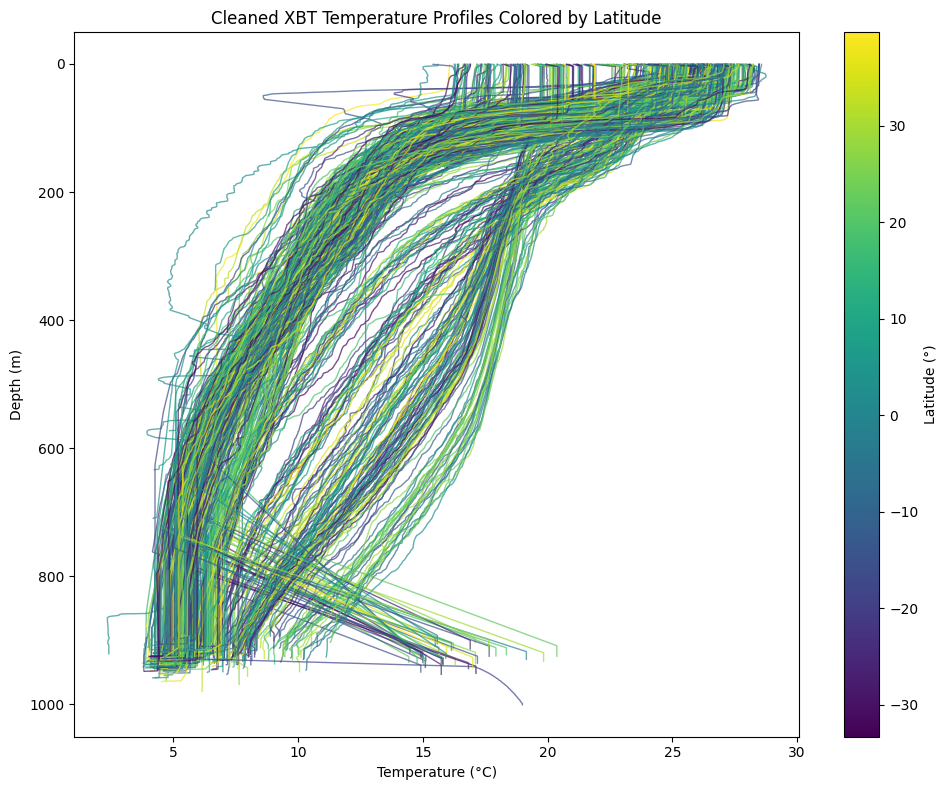

In [51]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Get list of all latitudes from cleaned profiles (assumes each profile has constant latitude)
latitudes = [df['Latitude'].iloc[0] for df in cleaned_profiles]

# Normalize latitudes to a 0–1 range for consistent colormap mapping
norm = mcolors.Normalize(vmin=min(latitudes), vmax=max(latitudes))
cmap = plt.get_cmap('viridis')  # Choose 'viridis' colormap for smooth perceptual gradient

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each cleaned profile
for df in cleaned_profiles:
    lat = df['Latitude'].iloc[0]         # Get latitude of this profile
    color = cmap(norm(lat))              # Map latitude to a color
    ax.plot(df['Temp'], df['Depth'],     # Plot temperature vs depth
            color=color, linewidth=1, alpha=0.7)  # Slight transparency for layering

# Invert y-axis so depth increases downward (oceanographic convention)
ax.invert_yaxis()

# Set axis labels and plot title
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Depth (m)')
ax.set_title('Cleaned XBT Temperature Profiles Colored by Latitude')

# Create a scalar mappable to attach the colormap to the colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed for older matplotlib versions

# Add colorbar to figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Latitude (°)')  # Label for color scale

# Optimize layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'cleaned_xbt_profiles_by_latitude.png'), dpi=300)

# Display the figure
plt.show()

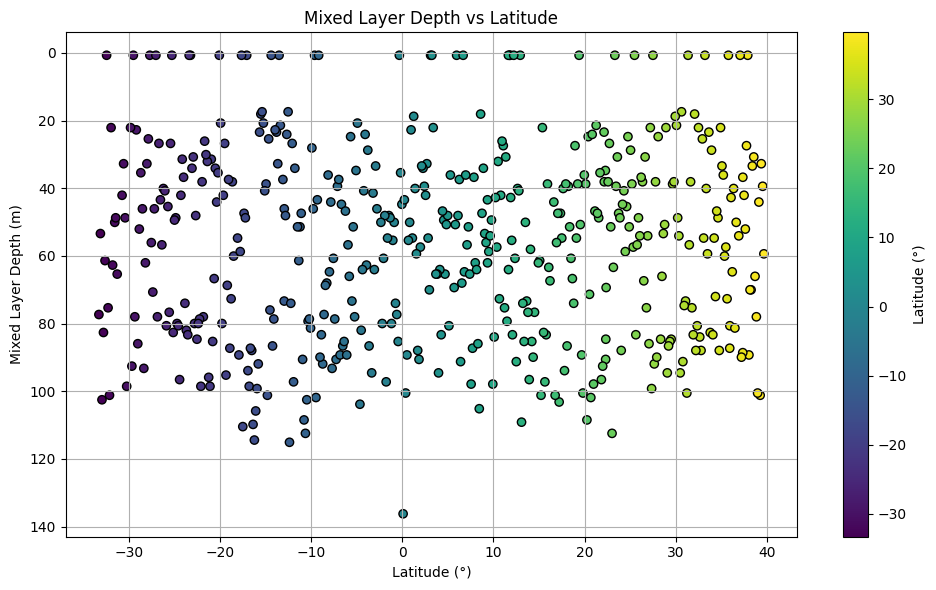

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Settings ---
mld_threshold = 0.5  # Criterion: MLD = depth where temp drops 0.5°C from surface
mld_list = []        # Store MLD results for each profile

# --- Compute MLD from cleaned profiles ---
for df in cleaned_profiles:
    profile_name = df['Profile'].iloc[0]
    lat = df['Latitude'].iloc[0]
    
    shallow = df[df['Depth'] <= 10]
    if shallow.empty:
        continue
    
    surface_temp = shallow['Temp'].mean()

    # Find first depth where temp drops 0.5°C from surface
    mld_candidates = df[df['Temp'] <= surface_temp - mld_threshold]
    
    if not mld_candidates.empty:
        mld_depth = mld_candidates.iloc[0]['Depth']
        mld_list.append({'Latitude': lat, 'MLD': mld_depth, 'Profile': profile_name})
    else:
        # No MLD found in profile
        continue

# --- Create DataFrame ---
mld_df = pd.DataFrame(mld_list)

# --- Plot: MLD vs Latitude ---
plt.figure(figsize=(10, 6))
plt.scatter(mld_df['Latitude'], mld_df['MLD'], c=mld_df['Latitude'], cmap='viridis', edgecolor='k')
plt.xlabel("Latitude (°)")
plt.ylabel("Mixed Layer Depth (m)")
plt.title("Mixed Layer Depth vs Latitude")
plt.gca().invert_yaxis()
plt.colorbar(label="Latitude (°)")
plt.grid(True)
plt.tight_layout()

# --- Save plot ---
plot_path = os.path.join(figures_dir, 'mld_vs_latitude.png')
plt.savefig(plot_path, dpi=300)
plt.show()

# --- Save data ---
mld_df.to_csv(os.path.join(data_dir, 'mld_data.csv'), index=False)

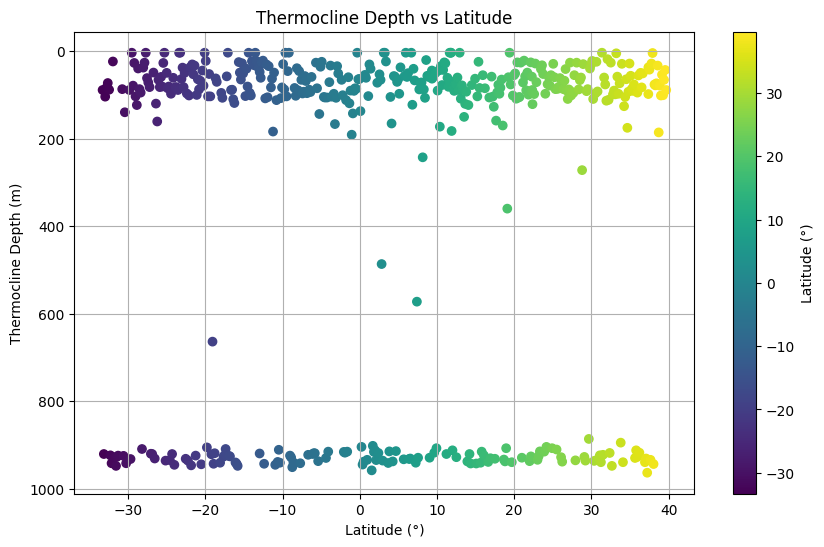

In [53]:
import matplotlib.pyplot as plt

# --- Thermocline detection and plotting ---

thermocline_data = []

for df in cleaned_profiles:
    # Ensure the DataFrame is sorted
    df = df.sort_values('Depth').reset_index(drop=True)
    
    # Calculate vertical gradient
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    gradient = temp_diff / depth_diff
    
    # Find depth of maximum gradient (i.e. steepest negative slope)
    if gradient.isnull().all():
        continue  # skip if all values are NaN

    max_grad_idx = gradient.abs().idxmax()
    thermocline_depth = df.loc[max_grad_idx, 'Depth']
    latitude = df['Latitude'].iloc[0]

    thermocline_data.append((latitude, thermocline_depth))

# Convert to DataFrame
thermo_df = pd.DataFrame(thermocline_data, columns=['Latitude', 'ThermoclineDepth'])

# Sort by latitude
thermo_df = thermo_df.sort_values('Latitude')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(thermo_df['Latitude'], thermo_df['ThermoclineDepth'], c=thermo_df['Latitude'], cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(label='Latitude (°)')
plt.xlabel('Latitude (°)')
plt.ylabel('Thermocline Depth (m)')
plt.title('Thermocline Depth vs Latitude')
plt.grid(True)

# Save
plt.savefig(os.path.join(figures_dir, 'thermocline_vs_latitude.png'), dpi=300)
plt.show()

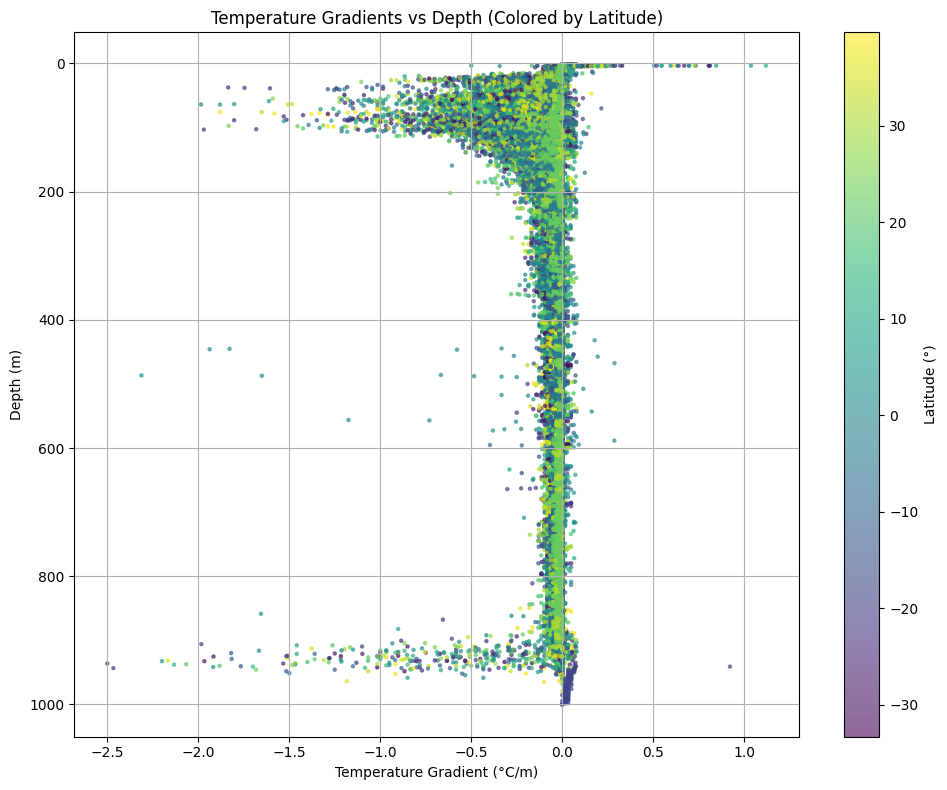

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# --- Initialize Lists ---
gradients = []   # Stores temperature gradients (°C/m)
depths = []      # Corresponding depths (m)
latitudes = []   # Latitude for each point (used for color mapping)

# --- Loop through cleaned XBT profiles ---
for df in cleaned_profiles:
    df = df.sort_values('Depth').reset_index(drop=True)  # Ensure top-down sorting

    # Compute temperature and depth differences
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    grad = temp_diff / depth_diff  # °C per meter

    # Append results, skipping first NaN caused by diff
    gradients.extend(grad[1:])
    depths.extend(df['Depth'][1:])
    latitudes.extend([df['Latitude'].iloc[0]] * (len(df) - 1))

# --- Normalize Latitude for Color Mapping ---
norm = mcolors.Normalize(vmin=min(latitudes), vmax=max(latitudes))
cmap = plt.get_cmap('viridis')  # Color scale
colors = [cmap(norm(lat)) for lat in latitudes]

# --- Create Scatter Plot ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    gradients, depths,
    c=latitudes, cmap=cmap, norm=norm,
    s=5, alpha=0.6
)

plt.gca().invert_yaxis()  # Oceanography convention: deeper = lower
plt.xlabel("Temperature Gradient (°C/m)")
plt.ylabel("Depth (m)")
plt.title("Temperature Gradients vs Depth (Colored by Latitude)")

# --- Add Colorbar ---
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Latitude (°)")

# --- Finalize and Save ---
plt.grid(True)
plt.tight_layout()

# Save the figure to the output directory
plt.savefig(os.path.join(figures_dir, "temperature_gradients_by_depth.png"), dpi=300)
plt.show()